In [63]:
%matplotlib inline


# Comparing different clustering algorithms on toy datasets


This example shows characteristics of different
clustering algorithms on datasets that are "interesting"
but still in 2D. With the exception of the last dataset,
the parameters of each of these dataset-algorithm pairs
has been tuned to produce good clustering results. Some
algorithms are more sensitive to parameter values than
others.

The last dataset is an example of a 'null' situation for
clustering: the data is homogeneous, and there is no good
clustering. For this example, the null dataset uses the
same parameters as the dataset in the row above it, which
represents a mismatch in the parameter values and the
data structure.

While these examples give some intuition about the
algorithms, this intuition might not apply to very high
dimensional data.



In [64]:
file_path = 'C:/Users/liwu/XstoreLogProject/data'
file_name = 'xstore_error_log_timevec.csv'
desc_file_name = ''

In [65]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import pandas as pd
import seaborn as sns

np.random.seed(0)

def process_dataset(file_path):
    errorLog = pd.read_csv(file_path)
    errorLog['oracle_error_code'] = errorLog.oracle_error_code.astype('category')

    errorLog['error_cat'] = errorLog.oracle_error_code.cat.codes
    errorLog['timevec'] = errorLog.timevec.apply(lambda x: np.array(list(map(float,x[1:-1].split(',')))))

    data = errorLog.timevec.values
   
    target = errorLog.error_cat.values
    #feature = errorLog.oracle_error_code.values

    #errorLogBunch = datasets.base.Bunch(data = data, target = target,feature = feature)
    errorLogBunch = pd.DataFrame(data = {"data" : errorLog.timevec, "target": errorLog.error_cat, 
                                         'feature': errorLog.oracle_error_code,
                                            'desc':errorLog.desc})

    return errorLogBunch

ds = process_dataset(file_path + '/' + file_name)





Automatically created module for IPython interactive environment


In [66]:
desc_file = file_path + '/' + ''
def find_description(desc_file, code):
    df = pd.read_csv(desc_file)

    

c:\users\liwu\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:68: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 3600x2880 with 0 Axes>

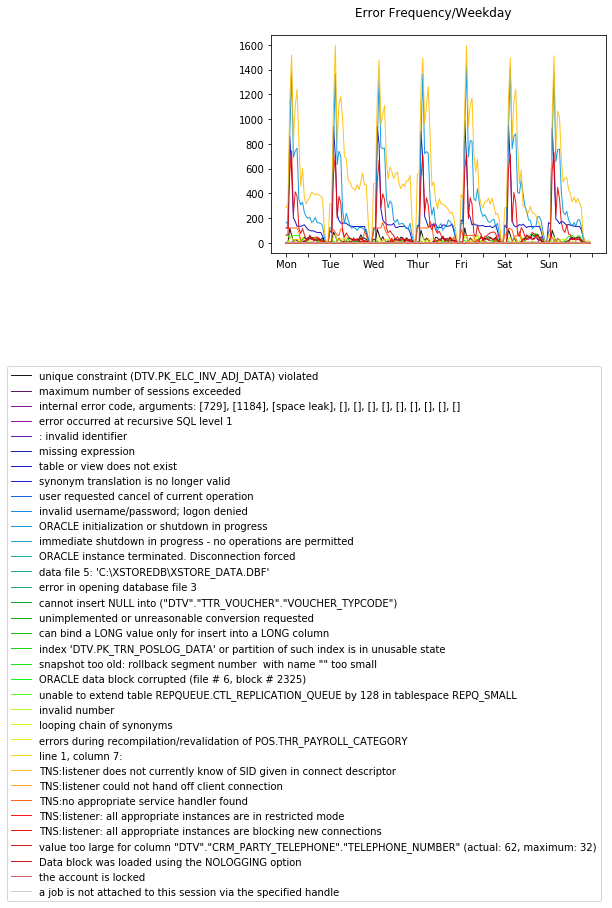

In [67]:
# ============
# Set up cluster parameters
# ============
plt.figure(1,figsize=(50, 40))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

#####TODO: modify these paramtres

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 2,
                'xi': 0.05,
                'min_cluster_size': 0.1}

# datasets = [
#     (noisy_circles, {'damping': .77, 'preference': -240,
#                      'quantile': .2, 'n_clusters': 2,
#                      'min_samples': 20, 'xi': 0.25}),
#     (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
#     (varied, {'eps': .18, 'n_neighbors': 2,
#               'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
#     (aniso, {'eps': .15, 'n_neighbors': 2,
#              'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
#     (blobs, {}),
#     (no_structure, {})

# update parameters with dataset-specific values
params = default_base.copy()



# preprocess dataset, split into training and test part
X = ds['data'].values
###convert the type to np float inside
X = np.vstack(X[:])

y = ds.target.values
y_feature = ds.feature.values
y_desc = ds.desc.values

def plot_raw(X_raw, y_raw):
    '''
    Plot the untransformed and unclustered raw dataset with label.
    X_raw:
    y_raw:
    '''
    
    fig = plt.figure(2)
    raw_fig = plt.subplot()
    palette = plt.cm.get_cmap('nipy_spectral', len(y_raw))


    for row in range(X_raw.shape[0]):
       
        plt.plot(X[row], marker='', linewidth=1, color = palette(row),alpha=0.9, label = y_raw[row])
    raw_fig.set_xticks(np.arange(0, 169, 12))
    labels = ['Mon', '','Tue','', 'Wed','', 'Thur','', 'Fri','', 'Sat','', 'Sun']
    raw_fig.set_xticklabels(labels)
    plt.legend(bbox_to_anchor = (1,-0.5))
    fig.suptitle('Error Frequency/Weekday')
    fig.show()
    return 

plot_raw(X,y_desc)





In [68]:
#X = StandardScaler().fit_transform(X)


#normalize dataset for easier parameter selection
#X = StandardScaler().fit_transform(X)

# estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

# connectivity matrix for structured Ward
connectivity = kneighbors_graph(
    X, n_neighbors=params['n_neighbors'], include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

# ============
# Create cluster objects
# ============



ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)

dbscan = cluster.DBSCAN(eps=params['eps'])
optics = cluster.OPTICS(min_samples=params['min_samples'],
                        xi=params['xi'],
                        min_cluster_size=params['min_cluster_size'])
affinity_propagation = cluster.AffinityPropagation(
damping=params['damping'], preference=params['preference'])

clustering_algorithms = {
    'MiniBatchKMeans':[],
    'AffinityPropagation': [affinity_propagation],
    'MeanShift': [ms],
    'SpectralClustering':[],
    'Ward':[],
    'AgglomerativeClustering':[],
    'DBSCAN': [dbscan],
    'OPTICS':[optics],
    'Birch':[],
    'GaussianMixture':[]
}



range_n_cluster = range(1,34)
for i in range_n_cluster:
    clustering_algorithms['MiniBatchKMeans'].append(cluster.MiniBatchKMeans(n_clusters= i))
    clustering_algorithms['AgglomerativeClustering'].append( cluster.AgglomerativeClustering(
    linkage="average", affinity="cityblock",
    n_clusters = i , connectivity=connectivity))
    clustering_algorithms['Birch'].append(cluster.Birch(n_clusters=i))
    clustering_algorithms['GaussianMixture'].append( mixture.GaussianMixture(
    n_components=i, covariance_type='full'))
    clustering_algorithms['Ward'].append(cluster.AgglomerativeClustering(
    n_clusters=i, linkage='ward',
    connectivity=connectivity))
    clustering_algorithms['SpectralClustering'].append(cluster.SpectralClustering(
    n_clusters=i, eigen_solver='arpack',
    affinity="nearest_neighbors"))
    
    


In [69]:
def num_cluster_comparison(range_n, algo_list, algo_name):
    '''
    Compare the number of clusters for algorithms.
    Currently supporting Kmeans.
    '''
    global X
    global y
    global y_feature
    global y_desc
    
    print(X)
    print(y)
    print(X.shape)
    print(y.shape)
    Sum_of_squared_distances = []
    for K, algorithm in zip(range_n,algo_list):
        algorithm.fit(X)

        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)
            
        Sum_of_squared_distances.append(algorithm.inertia_)
        
    plt.plot(range_n,Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

    return








    

    
#plt.show()    
    
#====
#Evaluation of performance 
#====

# metrics.silhouette_score(X, labels, metric='euclidean')

[[  3.   2. 118. ...   2.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  1.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   2. ...   0.   0.   0.]]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
(35, 168)
(35,)


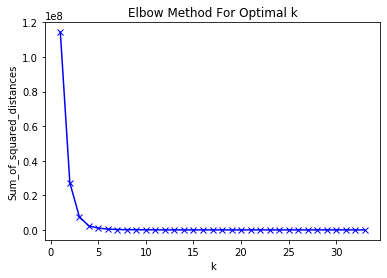

Algorithm AffinityPropagation generates 19 clusters
Cluster 0: Error ORA-00001 : unique constraint (DTV.PK_ELC_INV_ADJ_DATA) violated 
Cluster 1: Error ORA-00018 : maximum number of sessions exceeded 
Cluster 2: Error ORA-00600 : internal error code, arguments: [729], [1184], [space leak], [], [], [], [], [], [], [], [], [] 
Cluster 3: Error ORA-00604 : error occurred at recursive SQL level 1 
Cluster 4: Error ORA-00936 : missing expression 
Cluster 4: Error ORA-01089 : immediate shutdown in progress - no operations are permitted 
Cluster 4: Error ORA-01092 : ORACLE instance terminated. Disconnection forced 
Cluster 4: Error ORA-01502 : index 'DTV.PK_TRN_POSLOG_DATA' or partition of such index is in unusable state 
Cluster 5: Error ORA-00942 : table or view does not exist 
Cluster 6: Error ORA-01013 : user requested cancel of current operation 
Cluster 7: Error ORA-01033 : ORACLE initialization or shutdown in progress 
Cluster 8: Error ORA-01400 : cannot insert NULL into ("DTV"."TTR_VO

Algorithm OPTICS generates 1 clusters
Cluster -1: Error ORA-00001 : unique constraint (DTV.PK_ELC_INV_ADJ_DATA) violated 
Cluster -1: Error ORA-00600 : internal error code, arguments: [729], [1184], [space leak], [], [], [], [], [], [], [], [], [] 
Cluster -1: Error ORA-00942 : table or view does not exist 
Cluster -1: Error ORA-01033 : ORACLE initialization or shutdown in progress 
Cluster -1: Error ORA-01578 : ORACLE data block corrupted (file # 6, block # 2325) 
Cluster -1: Error ORA-12505 : TNS:listener does not currently know of SID given in connect descriptor 
Cluster -1: Error ORA-12519 : TNS:no appropriate service handler found 
Cluster -1: Error ORA-12528 : TNS:listener: all appropriate instances are blocking new connections 
Cluster -1: Error ORA-12899 : value too large for column "DTV"."CRM_PARTY_TELEPHONE"."TELEPHONE_NUMBER" (actual: 62, maximum: 32) 
Cluster 0: Error ORA-00018 : maximum number of sessions exceeded 
Cluster 0: Error ORA-00604 : error occurred at recursive S

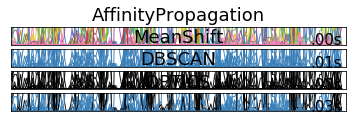

In [70]:
def fit_and_plot_result(name,algorithm):
    
    global plot_num
    global X
    global y
    global y_feature
    global y_desc
    
    t0 = time.time()

    # catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
        warnings.filterwarnings(
        "ignore",
        message="the number of connected components of the " +
        "connectivity matrix is [0-9]{1,2}" +
        " > 1. Completing it to avoid stopping the tree early.",
        category=UserWarning)
    warnings.filterwarnings(
        "ignore",
        message="Graph is not fully connected, spectral embedding" +
        " may not work as expected.",
        category=UserWarning)
    algorithm.fit(X)

    t1 = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X)

    ax = plt.subplot( len(clustering_algorithms),1, plot_num)
 
    plt.title(name, size=18)

    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                         '#f781bf', '#a65628', '#984ea3',
                                         '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
    
    #text result description
    algo_name = name
    num_cluster = max(y_pred) + 1
    
    print("Algorithm {} generates {} clusters".format(algo_name, num_cluster))
    
    # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    
    #Text Result
    for pred in np.unique(y_pred):
        for row in range(X.shape[0]):
            error_code = y_feature[row]
            error_desc = y_desc[row]
            cluster_id = y_pred[row]
            if cluster_id == pred:
                print("Cluster {}: Error {} : {} ".format(cluster_id, error_code, error_desc))
                
                
    #Visual Result
    for row in range(X.shape[0]):
        plt.plot(X[row], marker='', color=colors[y_pred[row]], linewidth=1, alpha=0.9)

    ax.set_xticks(np.arange(0, 169, 24))
    plt.xlim(0, 169)
    plt.ylim(0, 5)
    plt.xticks(())
    plt.yticks(())
    plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
             transform=plt.gca().transAxes, size=15,
             horizontalalignment='right')
    plot_num += 1
    return
   
for name, algorithms in clustering_algorithms.items():
    if len(algorithms) != 1:
        if name == 'MiniBatchKMeans':
            num_cluster_comparison(range_n_cluster, algorithms, name) 
        continue
    else:
        fit_and_plot_result(name,algorithms[0])



Algorithm MiniBatchKMeans generates 4 clusters
Cluster 0: Error ORA-00001 : unique constraint (DTV.PK_ELC_INV_ADJ_DATA) violated 
Cluster 0: Error ORA-00018 : maximum number of sessions exceeded 
Cluster 0: Error ORA-00600 : internal error code, arguments: [729], [1184], [space leak], [], [], [], [], [], [], [], [], [] 
Cluster 0: Error ORA-00604 : error occurred at recursive SQL level 1 
Cluster 0: Error ORA-00904 : : invalid identifier 
Cluster 0: Error ORA-00936 : missing expression 
Cluster 0: Error ORA-00980 : synonym translation is no longer valid 
Cluster 0: Error ORA-01013 : user requested cancel of current operation 
Cluster 0: Error ORA-01017 : invalid username/password; logon denied 
Cluster 0: Error ORA-01089 : immediate shutdown in progress - no operations are permitted 
Cluster 0: Error ORA-01092 : ORACLE instance terminated. Disconnection forced 
Cluster 0: Error ORA-01110 : data file 5: 'C:\XSTOREDB\XSTORE_DATA.DBF' 
Cluster 0: Error ORA-01116 : error in opening databas

Algorithm AgglomerativeClustering generates 4 clusters
Cluster 0: Error ORA-00942 : table or view does not exist 
Cluster 0: Error ORA-12528 : TNS:listener: all appropriate instances are blocking new connections 
Cluster 1: Error ORA-00001 : unique constraint (DTV.PK_ELC_INV_ADJ_DATA) violated 
Cluster 1: Error ORA-00018 : maximum number of sessions exceeded 
Cluster 1: Error ORA-00600 : internal error code, arguments: [729], [1184], [space leak], [], [], [], [], [], [], [], [], [] 
Cluster 1: Error ORA-00604 : error occurred at recursive SQL level 1 
Cluster 1: Error ORA-00904 : : invalid identifier 
Cluster 1: Error ORA-00936 : missing expression 
Cluster 1: Error ORA-00980 : synonym translation is no longer valid 
Cluster 1: Error ORA-01013 : user requested cancel of current operation 
Cluster 1: Error ORA-01017 : invalid username/password; logon denied 
Cluster 1: Error ORA-01089 : immediate shutdown in progress - no operations are permitted 
Cluster 1: Error ORA-01092 : ORACLE ins

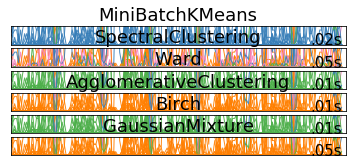

In [71]:
#
i = 4

num_clustering_algorithms = {
    'MiniBatchKMeans':[],
    'SpectralClustering':[],
    'Ward':[],
    'AgglomerativeClustering':[],
    'Birch':[],
    'GaussianMixture':[]
}

num_clustering_algorithms['MiniBatchKMeans'].append(cluster.MiniBatchKMeans(n_clusters= i))
num_clustering_algorithms['AgglomerativeClustering'].append( cluster.AgglomerativeClustering(
linkage="average", affinity="cityblock",
n_clusters = i , connectivity=connectivity))
num_clustering_algorithms['Birch'].append(cluster.Birch(n_clusters=i))
num_clustering_algorithms['GaussianMixture'].append( mixture.GaussianMixture(
n_components=i, covariance_type='full'))
num_clustering_algorithms['Ward'].append(cluster.AgglomerativeClustering(
n_clusters=i, linkage='ward',
connectivity=connectivity))
num_clustering_algorithms['SpectralClustering'].append(cluster.SpectralClustering(
n_clusters=i, eigen_solver='arpack',
affinity="nearest_neighbors"))

for name, algorithm in num_clustering_algorithms.items():
    fit_and_plot_result(name,algorithm[0])

